**Alumno:** César Emilio García Ávalos

**Actividad:** M5_AI1_Modelo lineal Gaussiano_modelos espaciales

In [8]:
install.packages(c("sf", "spdep", "dplyr", "ggplot2","osmdata","geosphere","MASS","earth","spatialreg","caret","spgwr","leaflet"))
library(spgwr)
library(leaflet)
library(spatialreg)
library(caret)
library(earth)
library(spdep)
library(MASS)
library(geosphere)
library(osmdata)
library(sf)
library(dplyr)
library(ggplot2)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘zoo’, ‘prodlim’, ‘wk’, ‘proxy’, ‘proj4’, ‘PROJ’, ‘crsmeta’, ‘plotrix’, ‘mvtnorm’, ‘TH.data’, ‘sandwich’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘lazyeval’, ‘terra’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’, ‘spData’, ‘deldir’, ‘e1071’, ‘sp’, ‘reproj’, ‘Formula’, ‘plotmo’, ‘coda’, ‘LearnBayes’, ‘multcomp’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘crosstalk’, ‘htmlwidgets’, ‘leaflet.providers’, ‘png’, ‘raster’


Loading required package: sp

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`


Attaching package: ‘spData’


The following object is masked _

In [9]:
# Cargar los datos
tabla <- read.csv("https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/table_5.05.csv", sep = ",", header = TRUE)

In [10]:
summary(tabla)

       X          longitude         latitude         price       
 Min.   :   1   Min.   :-3.836   Min.   :40.33   Min.   : 16.00  
 1st Qu.:1964   1st Qu.:-3.707   1st Qu.:40.41   1st Qu.: 56.00  
 Median :3941   Median :-3.702   Median :40.42   Median : 77.00  
 Mean   :3945   Mean   :-3.697   Mean   :40.42   Mean   : 97.57  
 3rd Qu.:5914   3rd Qu.:-3.695   3rd Qu.:40.43   3rd Qu.:110.00  
 Max.   :7905   Max.   :-3.567   Max.   :40.51   Max.   :999.00  
  room_type         minimum_nights  number_of_reviews review_scores_value
 Length:7799        Min.   :1.000   Min.   :  1.00    Min.   : 2.000     
 Class :character   1st Qu.:1.000   1st Qu.:  6.00    1st Qu.: 9.000     
 Mode  :character   Median :2.000   Median : 23.00    Median : 9.000     
                    Mean   :2.272   Mean   : 54.36    Mean   : 9.175     
                    3rd Qu.:3.000   3rd Qu.: 73.00    3rd Qu.:10.000     
                    Max.   :9.000   Max.   :643.00    Max.   :10.000     
 calculated_host_lis

In [11]:
unique(tabla$room_type)
unique(tabla$instant_bookable)

[1] "Entire home/apt"

[1] "f" "t"

In [12]:
sum(is.na(tabla))

[1] 0

In [13]:
# Añadir una pequeña perturbación aleatoria a la latitud y longitud
set.seed(123)
tabla$latitude <- tabla$latitude + runif(nrow(tabla)) / 1000
tabla$longitude <- tabla$longitude + runif(nrow(tabla)) / 1000

# Seleccionar un subconjunto de datos si hay más de 2000 filas
if (nrow(tabla) > 2000) {
  set.seed(1)
  tabla <- tabla[sample(nrow(tabla), 2000), ]
}
pisos<- tabla

In [14]:
coords <- cbind(tabla$longitude, tabla$latitude)
nb <- knn2nb(knearneigh(coords, k = 10))


	Moran I test under randomisation

data:  tabla$price  
weights: listw    

Moran I statistic standard deviate = 5.3507, p-value = 4.38e-08
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     4.974002e-02     -5.002501e-04      8.816061e-05 


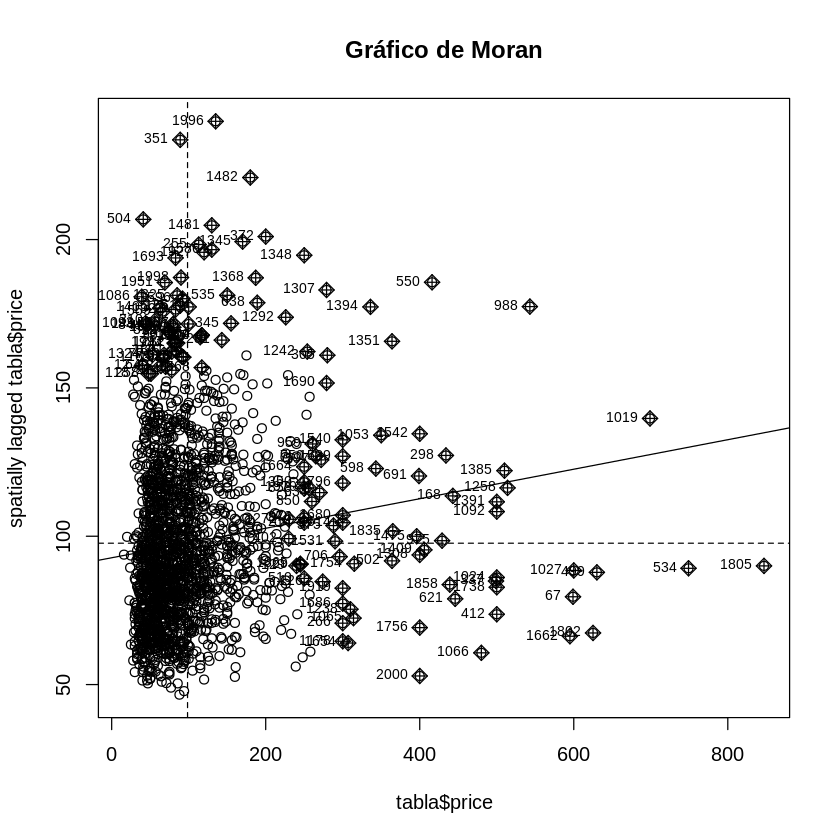

In [15]:
# Calcular la matriz de pesos espaciales
listw <- nb2listw(nb, style = "W")
moran_global <- moran.test(x = tabla$price, listw = listw)
moran.plot(x = tabla$price, listw = listw, main = "Gráfico de Moran")
moran_global

In [16]:
imoranlocal<-as.data.frame(localmoran(x = tabla$price, listw = listw))
tabla$registo<-1
#pl_pt(tabla,color2 = imoranlocal$Z.Ii,size2 =tabla$registo ,dd = 6)

In [17]:
install.packages("tmap")
library(tmap)
# Descargar los límites administrativos de Madrid desde OpenStreetMap
madrid <- opq("Madrid, Spain") %>%
  add_osm_feature(key = "admin_level", value = "8") %>%
  osmdata_sf()

# Extraer los límites administrativos
madrid_shp <- madrid$osm_multipolygons

# Convertir los datos de precios a un objeto sf
tabla_sf <- st_as_sf(tabla, coords = c("longitude", "latitude"), crs = 4326)

# Agregar los resultados de LISA a los datos de precios
tabla_sf$Z.li <- imoranlocal[, "Z.Ii"]

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘geometries’, ‘jsonify’, ‘rapidjsonr’, ‘sfheaders’, ‘lwgeom’, ‘dichromat’, ‘XML’, ‘geojsonsf’, ‘tmaptools’, ‘stars’, ‘widgetframe’, ‘leafsync’, ‘leafem’, ‘abind’


Breaking News: tmap 3.x is retiring. Please test v4, e.g. with
remotes::install_github('r-tmap/tmap')

tmap mode set to interactive viewing



In [25]:
# Crear el mapa usando tmap
tmap_mode("view")
tm_shape(madrid_shp) +
  tm_borders() +
tm_shape(tabla_sf) +
  tm_dots(col = "Z.li", style = "quantile", palette = "viridis", title = "Z.li") +
  tm_layout(title = "Test LISA: Z.li en Madrid")+
  tm_view()

tmap mode set to interactive viewing



Los resultados del Test de Moran I proporcionan una fuerte evidencia de autocorrelación espacial global en la variable precio. Esto significa que los precios en ubicaciones cercanas tienden a ser similares, sugiriendo la presencia de clusters de precios altos y bajos. El valor de p-value 4.38e-08 por debajo del nivel de significancia (generalmente 0.05) indica que se puede rechazar la hipótesis nula de no autocorrelación espacial. En este caso, el valor p proporciona una evidencia de que existe autocorrelación espacial en los precios.

In [128]:
pisos <- dplyr::select(pisos,-price,-room_type)

In [129]:
modelo_lineal <- glm(logprice ~ ., data = pisos, family = gaussian)
# Resumen del modelo
summary(modelo_lineal)


Call:
glm(formula = logprice ~ ., family = gaussian, data = pisos)

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     1.965e+01  8.309e+01   0.236  0.81307    
X                              -9.331e-07  5.644e-06  -0.165  0.86871    
longitude                      -1.387e+00  8.859e-01  -1.566  0.11763    
latitude                       -5.289e-01  2.100e+00  -0.252  0.80120    
minimum_nights                 -2.142e-02  7.642e-03  -2.802  0.00512 ** 
number_of_reviews               5.935e-04  2.835e-04   2.093  0.03645 *  
review_scores_value             3.171e-02  1.002e-02   3.165  0.00157 ** 
calculated_host_listings_count -1.297e-03  2.888e-04  -4.492 7.47e-06 ***
bedrooms                        1.963e-01  2.075e-02   9.463  < 2e-16 ***
reviews_per_month              -1.339e-01  1.247e-02 -10.731  < 2e-16 ***
beds                            2.589e-02  1.194e-02   2.168  0.03027 *  
accommodates                 


	Moran I test under randomisation

data:  modelo_lineal$residuals  
weights: listw    

Moran I statistic standard deviate = 5.5471, p-value = 1.452e-08
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     5.183294e-02     -5.002501e-04      8.900528e-05 


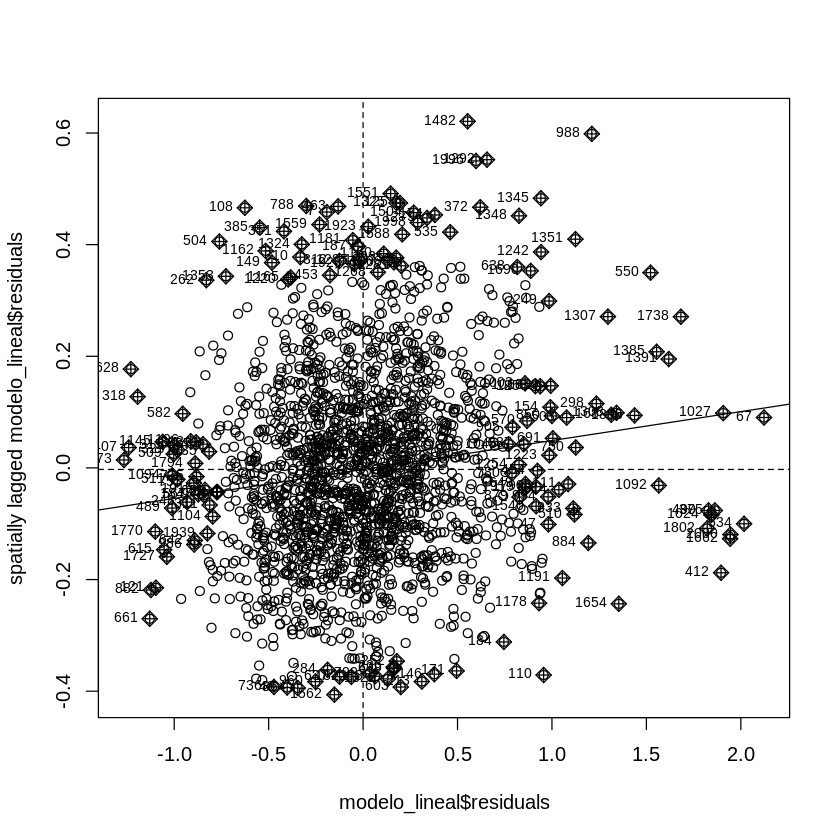

In [130]:
moran.test(x=modelo_lineal$residuals, listw = listw)
moran.plot(x=modelo_lineal$residuals, listw = listw)

Los resultados del Test de Moran I para los residuos del modelo lineal indican que hay una dependencia espacial significativa en los residuos del modelo. Esto sugiere que el modelo lineal no ha capturado completamente la estructura espacial de los datos, lo que puede implicar que hay patrones espaciales en los datos que no han sido modelados adecuadamente.

In [147]:
backward <- stepAIC(modelo_lineal,trace=FALSE,direction="backward")
backward$anova
summary(backward)

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,1976,374.2435,2373.763
- instant_bookable,1,0.0008946576,1977,374.2444,2371.767
- availability_90,1,0.0033026326,1978,374.2477,2369.785
- X,1,0.0047966191,1979,374.2525,2367.811
- latitude,1,0.0121237643,1980,374.2646,2365.876
- Piso,1,0.0127473307,1981,374.2774,2363.944
- Vecinos,1,0.0401067563,1982,374.3175,2362.158
- tv_ports,1,0.0605865394,1983,374.3781,2360.482
- phone_ports,1,0.2765444552,1984,374.6546,2359.958



Call:
glm(formula = logprice ~ longitude + minimum_nights + number_of_reviews + 
    review_scores_value + calculated_host_listings_count + bedrooms + 
    reviews_per_month + beds + accommodates + availability_30 + 
    availability_60 + Distancia_Centro + Distancia_Norte + Distancia_Sur + 
    ventanas, family = gaussian, data = pisos)

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -1.0595031  2.7515423  -0.385  0.70024    
longitude                      -1.2166107  0.7252681  -1.677  0.09361 .  
minimum_nights                 -0.0211169  0.0074778  -2.824  0.00479 ** 
number_of_reviews               0.0006094  0.0002202   2.767  0.00571 ** 
review_scores_value             0.0318333  0.0099855   3.188  0.00146 ** 
calculated_host_listings_count -0.0012947  0.0002809  -4.609 4.31e-06 ***
bedrooms                        0.1965373  0.0206527   9.516  < 2e-16 ***
reviews_per_month              -0.1341024  0.0109624

In [163]:
formula <- as.formula("logprice ~ minimum_nights + number_of_reviews +
    review_scores_value + calculated_host_listings_count + bedrooms +
    reviews_per_month + beds + accommodates + availability_30 +
    availability_60 + Distancia_Centro + Distancia_Norte + Distancia_Sur +
    ventanas + distancia_bancos")

Se ha realizado un backward con el propósito de mejorar el modelo inicialmente realizado

In [164]:
# Definir el área de Madrid
bbox <- getbb("Madrid, Spain")

# Consultar OSM para obtener ubicaciones de oficinas bancarias
bancos <- opq(bbox = bbox) %>%
  add_osm_feature(key = 'amenity', value = 'bank') %>%
  osmdata_sf()

# Extraer las coordenadas de los bancos
bancos_coords <- bancos$osm_points %>% st_coordinates()

In [165]:
# Crear una función para calcular la distancia mínima
calcular_distancia_minima <- function(lat, lon, bancos_coords) {
  distancias <- distm(c(lon, lat), bancos_coords)
  min(distancias)
}

pisosBank<-pisos
# Calcular la distancia mínima para cada observación en tus datos
pisosBank$distancia_bancos <- mapply(calcular_distancia_minima, pisos$latitude, pisos$longitude, MoreArgs = list(bancos_coords = bancos_coords))

In [166]:
modelo_lineal_completo <- glm(formula=formula, data = pisosBank, family = gaussian)
# Resumen del modelo
summary(modelo_lineal_completo)


Call:
glm(formula = formula, family = gaussian, data = pisosBank)

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     3.538e+00  1.360e-01  26.004  < 2e-16 ***
minimum_nights                 -2.086e-02  7.471e-03  -2.793 0.005277 ** 
number_of_reviews               6.450e-04  2.200e-04   2.932 0.003411 ** 
review_scores_value             3.336e-02  9.987e-03   3.341 0.000851 ***
calculated_host_listings_count -1.299e-03  2.807e-04  -4.628 3.93e-06 ***
bedrooms                        1.942e-01  2.067e-02   9.398  < 2e-16 ***
reviews_per_month              -1.358e-01  1.095e-02 -12.404  < 2e-16 ***
beds                            2.417e-02  1.187e-02   2.036 0.041897 *  
accommodates                    4.226e-02  9.204e-03   4.592 4.67e-06 ***
availability_30                 8.956e-03  2.668e-03   3.357 0.000802 ***
availability_60                -4.286e-03  1.338e-03  -3.204 0.001376 ** 
Distancia_Centro              


	Moran I test under randomisation

data:  modelo_lineal_completo$residuals  
weights: listw    

Moran I statistic standard deviate = 5.4423, p-value = 2.629e-08
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     5.084525e-02     -5.002501e-04      8.900902e-05 


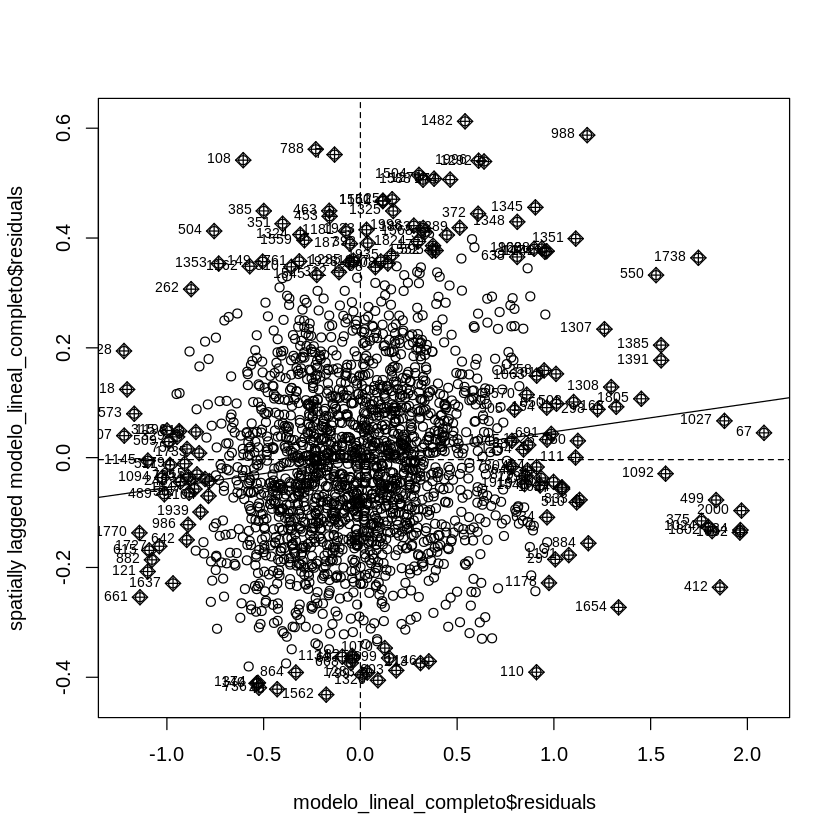

In [167]:
moran.test(x=modelo_lineal_completo$residuals, listw = listw)
moran.plot(x=modelo_lineal_completo$residuals, listw = listw)

In [168]:
paste("Residuos del modelo lineal", sum((modelo_lineal$residuals)**2))
paste("Residuos del modelo lineal con distancia a bancos", sum((modelo_lineal_completo$residuals)**2))

[1] "Residuos del modelo lineal 374.243525993805"

[1] "Residuos del modelo lineal con distancia a bancos 373.972648743769"

Los residuos del modelo lineal original vs los residuos del modelo con la variable distancia_bancos se reduce, sin embargo los resultados del Test de Moran I para los residuos del nuevo modelo indican que sigue habiendo una dependencia espacial significativa en los residuos del modelo, incluso después de haber añadido la variable de distancia mínima a las oficinas bancarias. Esto sugiere que el modelo lineal con la nueva variable no ha capturado completamente la estructura espacial de los datos.

In [169]:
modelo_sar <- lagsarlm(formula = formula, data= pisosBank, listw = listw)
summary(modelo_sar)


Call:lagsarlm(formula = formula, data = pisosBank, listw = listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.257066 -0.282922 -0.011674  0.237808  2.078860 

Type: lag 
Coefficients: (asymptotic standard errors) 
                                  Estimate  Std. Error  z value  Pr(>|z|)
(Intercept)                     2.6401e+00  2.1178e-01  12.4661 < 2.2e-16
minimum_nights                 -2.0631e-02  7.3722e-03  -2.7986 0.0051332
number_of_reviews               5.9012e-04  2.1718e-04   2.7172 0.0065829
review_scores_value             3.2564e-02  9.8553e-03   3.3042 0.0009524
calculated_host_listings_count -1.3016e-03  2.7694e-04  -4.7000 2.602e-06
bedrooms                        1.9032e-01  2.0402e-02   9.3284 < 2.2e-16
reviews_per_month              -1.3151e-01  1.0823e-02 -12.1508 < 2.2e-16
beds                            2.4622e-02  1.1713e-02   2.1021 0.0355447
accommodates                    4.1872e-02  9.0824e-03   4.6103 4.022e-06
availability_30        

In [170]:
# Ajustar el modelo SEM
modelo_sem <- errorsarlm(formula = formula, data = pisosBank, listw = listw)
summary(modelo_sem)


Call:errorsarlm(formula = formula, data = pisosBank, listw = listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.276534 -0.283725 -0.010943  0.238422  2.086382 

Type: error 
Coefficients: (asymptotic standard errors) 
                                  Estimate  Std. Error  z value  Pr(>|z|)
(Intercept)                     3.5295e+00  1.5166e-01  23.2730 < 2.2e-16
minimum_nights                 -2.0845e-02  7.3909e-03  -2.8204 0.0047961
number_of_reviews               5.8825e-04  2.1728e-04   2.7074 0.0067816
review_scores_value             3.2626e-02  9.8940e-03   3.2976 0.0009752
calculated_host_listings_count -1.2781e-03  2.7817e-04  -4.5948 4.332e-06
bedrooms                        1.9054e-01  2.0364e-02   9.3571 < 2.2e-16
reviews_per_month              -1.3221e-01  1.0861e-02 -12.1729 < 2.2e-16
beds                            2.4513e-02  1.1742e-02   2.0877 0.0368237
accommodates                    4.2319e-02  9.1304e-03   4.6350 3.570e-06
availability_30    

In [171]:
paste("Residuos del modelo lineal", sum((modelo_lineal$residuals)**2))
paste("Residuos del modelo lineal con distancia a bancos", sum((modelo_lineal_completo$residuals)**2))
paste("Residuos del modelo SAR", sum((modelo_sar$residuals)**2))
paste("Residuos del modelo SEM", sum((modelo_sem$residuals)**2))

[1] "Residuos del modelo lineal 374.243525993805"

[1] "Residuos del modelo lineal con distancia a bancos 373.972648743769"

[1] "Residuos del modelo SAR 367.073131909402"

[1] "Residuos del modelo SEM 368.035969796948"

In [178]:
#Resultados modelo SAR
moran.test(x=modelo_sar$residuals, listw = listw)
summary(modelo_sar)


	Moran I test under randomisation

data:  modelo_sar$residuals  
weights: listw    

Moran I statistic standard deviate = -0.15811, p-value = 0.5628
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -1.991828e-03     -5.002501e-04      8.900184e-05 



Call:lagsarlm(formula = formula, data = pisosBank, listw = listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.257066 -0.282922 -0.011674  0.237808  2.078860 

Type: lag 
Coefficients: (asymptotic standard errors) 
                                  Estimate  Std. Error  z value  Pr(>|z|)
(Intercept)                     2.6401e+00  2.1178e-01  12.4661 < 2.2e-16
minimum_nights                 -2.0631e-02  7.3722e-03  -2.7986 0.0051332
number_of_reviews               5.9012e-04  2.1718e-04   2.7172 0.0065829
review_scores_value             3.2564e-02  9.8553e-03   3.3042 0.0009524
calculated_host_listings_count -1.3016e-03  2.7694e-04  -4.7000 2.602e-06
bedrooms                        1.9032e-01  2.0402e-02   9.3284 < 2.2e-16
reviews_per_month              -1.3151e-01  1.0823e-02 -12.1508 < 2.2e-16
beds                            2.4622e-02  1.1713e-02   2.1021 0.0355447
accommodates                    4.1872e-02  9.0824e-03   4.6103 4.022e-06
availability_30        

In [179]:
#RESULTADOS MODELO SEM
moran.test(x=modelo_sem$residuals, listw = listw)
summary(modelo_sem)


	Moran I test under randomisation

data:  modelo_sem$residuals  
weights: listw    

Moran I statistic standard deviate = -0.10717, p-value = 0.5427
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -1.511278e-03     -5.002501e-04      8.900293e-05 



Call:errorsarlm(formula = formula, data = pisosBank, listw = listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.276534 -0.283725 -0.010943  0.238422  2.086382 

Type: error 
Coefficients: (asymptotic standard errors) 
                                  Estimate  Std. Error  z value  Pr(>|z|)
(Intercept)                     3.5295e+00  1.5166e-01  23.2730 < 2.2e-16
minimum_nights                 -2.0845e-02  7.3909e-03  -2.8204 0.0047961
number_of_reviews               5.8825e-04  2.1728e-04   2.7074 0.0067816
review_scores_value             3.2626e-02  9.8940e-03   3.2976 0.0009752
calculated_host_listings_count -1.2781e-03  2.7817e-04  -4.5948 4.332e-06
bedrooms                        1.9054e-01  2.0364e-02   9.3571 < 2.2e-16
reviews_per_month              -1.3221e-01  1.0861e-02 -12.1729 < 2.2e-16
beds                            2.4513e-02  1.1742e-02   2.0877 0.0368237
accommodates                    4.2319e-02  9.1304e-03   4.6350 3.570e-06
availability_30    

*Modelo SAR: El valor de 𝜌 (0.21156) es significativo, lo que confirma que hay una dependencia espacial en la variable dependiente. Esto justifica el uso del modelo SAR para capturar la estructura espacial de los datos. Los resultados del Test de Moran I para los residuos del modelo SAR indican que no hay una dependencia espacial significativa en los residuos del modelo SAR. Esto sugiere que el modelo SAR ha capturado adecuadamente la estructura espacial de los datos, eliminando la autocorrelación espacial en los residuos.

*Modelo SEM: El valor de 𝜆 (0.22312) es significativo, lo que confirma que hay una dependencia espacial en los errores del modelo. Esto justifica el uso del modelo SEM para capturar la estructura espacial de los datos. Los resultados del Test de Moran I para los residuos del modelo SEM indican que no hay una dependencia espacial significativa en los residuos del modelo SEM. Esto sugiere que el modelo SEM ha capturado adecuadamente la estructura espacial de los datos, eliminando la autocorrelación espacial en los residuos.

In [173]:
# Definir el número de folds para la validación cruzada
num_folds <- 5

# Inicializar vectores para almacenar resultados de rendimiento
mse_values <- numeric(num_folds)
mae_values <- numeric(num_folds)
r_squared_values <- numeric(num_folds)

# Realizar la validación cruzada
for (fold in 1:num_folds) {
  # Generar índices de división aleatorios
  fold_indices <- createDataPartition(pisosBank$logprice, times = 1, p = 0.7, list = FALSE)

  # Subconjuntos de entrenamiento y prueba
  train_data <- pisosBank[fold_indices, ]
  test_data <- pisosBank[-fold_indices, ]

  # Crear matriz de pesos espaciales solo con los datos de entrenamiento de este fold
 coords_train <- cbind(train_data$longitude, train_data$latitude)
 nb_train <- knn2nb(knearneigh(coords_train, k = 10))
 train_listw <- nb2listw(nb_train, style = "W")

 # Crear matriz de pesos espaciales solo con los datos de prueba de este fold
 coords_test <- cbind(test_data$longitude, test_data$latitude)
 nb_test <- knn2nb(knearneigh(coords_test, k = 10))
 test_listw <- nb2listw(nb_test, style = "W")
 row.names(test_data) <- test_data$region.id

  # Ajustar el modelo SAR en el subconjunto de entrenamiento
  modelo_sar_fold <- lagsarlm(logprice ~ ., data = train_data, listw = train_listw)

  # Realizar predicciones en el conjunto de prueba
  predicciones <- predict(modelo_sar_fold, newdata = test_data, listw = test_listw)

  # Calcular métricas de rendimiento
  mse_values[fold] <- mean((test_data$logprice - predicciones)^2)
  mae_values[fold] <- mean(abs(test_data$logprice - predicciones))
  r_squared_values[fold] <- cor(test_data$logprice, predicciones)^2
}

# Calcular el promedio de las métricas de rendimiento
mean_mse <- mean(mse_values)
mean_mae <- mean(mae_values)
mean_r_squared <- mean(r_squared_values)

# Imprimir resultados
cat("MSE promedio:", mean_mse, "\n")
cat("MAE promedio:", mean_mae, "\n")
cat("R cuadrado promedio:", mean_r_squared, "\n")


Warning message in predict.Sarlm(modelo_sar_fold, newdata = test_data, listw = test_listw):
“some region.id are both in data and newdata”
Warning message in predict.Sarlm(modelo_sar_fold, newdata = test_data, listw = test_listw):
“some region.id are both in data and newdata”
Warning message in predict.Sarlm(modelo_sar_fold, newdata = test_data, listw = test_listw):
“some region.id are both in data and newdata”
Warning message in predict.Sarlm(modelo_sar_fold, newdata = test_data, listw = test_listw):
“some region.id are both in data and newdata”
Warning message in predict.Sarlm(modelo_sar_fold, newdata = test_data, listw = test_listw):
“some region.id are both in data and newdata”


MSE promedio: 0.1854905 
MAE promedio: 0.3304503 
R cuadrado promedio: 0.3473576 


In [174]:
# Ajustar modelo GWR y seleccionar ancho de banda automáticamente
tabla$residuos<-modelo_sem$residuals
puntos_sp<-tabla
coordinates(puntos_sp)<- c("longitude","latitude")
proj4string(puntos_sp) <- CRS("+proj=longlat +datum=WGS84")
#Obtenemos el mejor BW
bw <- gwr.sel(residuos~1, data=puntos_sp)

paste("El mejor ancho de banda es:",bw)

Bandwidth: 10.05937 CV score: 368.4182 
Bandwidth: 16.26016 CV score: 368.4103 
Bandwidth: 20.09246 CV score: 368.4083 
Bandwidth: 21.59043 CV score: 368.4078 
Bandwidth: 23.38674 CV score: 368.4073 
Bandwidth: 24.49693 CV score: 368.4071 
Bandwidth: 25.18306 CV score: 368.4069 
Bandwidth: 25.60711 CV score: 368.4068 
Bandwidth: 25.86919 CV score: 368.4068 
Bandwidth: 26.03116 CV score: 368.4068 
Bandwidth: 26.13127 CV score: 368.4067 
Bandwidth: 26.19313 CV score: 368.4067 
Bandwidth: 26.23137 CV score: 368.4067 
Bandwidth: 26.255 CV score: 368.4067 
Bandwidth: 26.26961 CV score: 368.4067 
Bandwidth: 26.27863 CV score: 368.4067 
Bandwidth: 26.28421 CV score: 368.4067 
Bandwidth: 26.28766 CV score: 368.4067 
Bandwidth: 26.28979 CV score: 368.4067 
Bandwidth: 26.29111 CV score: 368.4067 
Bandwidth: 26.29192 CV score: 368.4067 
Bandwidth: 26.29243 CV score: 368.4067 
Bandwidth: 26.29274 CV score: 368.4067 
Bandwidth: 26.29293 CV score: 368.4067 
Bandwidth: 26.29305 CV score: 368.4067 
Ba

Warning message in gwr.sel(residuos ~ 1, data = puntos_sp):
“Bandwidth converged to upper bound:26.2932400266073”


[1] "El mejor ancho de banda es: 26.2931666357708"

In [175]:
g <- gwr(residuos~1, data=puntos_sp, bandwidth=bw)